In [1]:
import pyspark
from pyspark.sql import SparkSession
import time

spark = SparkSession.builder \
    .appName("spotify-datalake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.memory", "1024M") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
sc = spark.sparkContext


:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/lucaslaredo/.ivy2/cache
The jars for the packages stored in: /home/lucaslaredo/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f96737e7-e4be-4eb3-84d3-20b967f2182d;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 236ms :: artifacts dl 11ms
	:: modules in use:
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3 

In [2]:
# playlist paths
playlists_v1_path = '/shared/sampled/playlists_v1.json'
playlists_v2_path = '/shared/sampled/playlists_v2.json'
playlists_v3_path = '/shared/sampled/playlists_v3.json'

# tracks paths
tracks_v1_path = '/shared/sampled/tracks_v1.json'
tracks_v2_path = '/shared/sampled/tracks_v2.json'
tracks_v3_path = '/shared/sampled/tracks_v3.json'

# Task 1

## Bronze layer

In [3]:
playlists_v1_df = spark.read.json(playlists_v1_path)
tracks_v1_df = spark.read.json(tracks_v1_path)

In [4]:
playlists_v1_df.columns

['collaborative', 'description', 'name', 'pid']

In [5]:
tracks_v1_df.columns

['album_name',
 'album_uri',
 'artist_name',
 'artist_uri',
 'duration_ms',
 'pid',
 'pos',
 'track_name',
 'track_uri']

## Silver layer

In [6]:
from pyspark.sql.functions import col

song_information = tracks_v1_df.select(
    "track_name",
    "track_uri",
    "duration_ms",
    "album_uri",
    "artist_uri"
).distinct()

In [7]:
from pyspark.sql import functions as F

album_information = tracks_v1_df.select(
    "album_name",
    "album_uri",
    "artist_uri"
).distinct()

In [8]:
artists_information = tracks_v1_df.select(
    "artist_name",
    "artist_uri"
).distinct()

In [9]:
playlists_information = playlists_v1_df.select(
    "name",
    "pid",
    "description",
    "collaborative"
).distinct()

In [10]:
playlist_tracks_information = tracks_v1_df.select(
    "pid",
    "pos",
    "track_uri",
    "album_uri",
    "artist_uri"
)

In [11]:
# save all to datalake
# PARQUET
parquet_start_time = time.time()
song_information.write.mode("overwrite").parquet("./silver/parquet/songs/")
album_information.write.mode("overwrite").parquet("./silver/parquet/album_information/")
artists_information.write.mode("overwrite").parquet("./silver/parquet/artists_information/")
playlists_information.write.mode("overwrite").parquet("./silver/parquet/playlists/")
playlist_tracks_information.write.mode("overwrite").parquet("./silver/parquet/playlist_tracks/")
silver_write_parquet_time = time.time() - parquet_start_time

# JSON
json_start_time = time.time()
song_information.write.mode("overwrite").json("./silver/json/songs/")
album_information.write.mode("overwrite").json("./silver/json/album_information/")
artists_information.write.mode("overwrite").json("./silver/json/artists_information/")
playlists_information.write.mode("overwrite").json("./silver/json/playlists/")
playlist_tracks_information.write.mode("overwrite").json("./silver/json/playlist_tracks/")
silver_write_json_time = time.time() - json_start_time

25/02/03 23:44:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/02/03 23:44:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/02/03 23:44:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
                                                                                

In [12]:
song_information.columns

['track_name', 'track_uri', 'duration_ms', 'album_uri', 'artist_uri']

In [13]:
album_information.columns

['album_name', 'album_uri', 'artist_uri']

In [14]:
artists_information.columns

['artist_name', 'artist_uri']

In [15]:
playlists_information.columns

['name', 'pid', 'description', 'collaborative']

In [16]:
playlist_tracks_information.columns

['pid', 'pos', 'track_uri', 'album_uri', 'artist_uri']

# Gold Layer

In [17]:
read_parquet_start_time = time.time()
silver_playlist_tracks = spark.read.parquet("./silver/parquet/playlist_tracks/")
silver_playlists = spark.read.parquet("./silver/parquet/playlists/")
silver_songs = spark.read.parquet("./silver/parquet/songs/")
silver_artists = spark.read.parquet("./silver/parquet/artists_information/")
silver_album = spark.read.parquet("./silver/parquet/album_information/")
silver_read_parquet_time = time.time() - read_parquet_start_time

read_json_start_time = time.time()
json_silver_playlist_tracks = spark.read.json("./silver/json/playlist_tracks/")
json_silver_playlists = spark.read.json("./silver/json/playlists/")
json_silver_songs = spark.read.json("./silver/json/songs/")
json_silver_artists = spark.read.json("./silver/json/artists_information/")
json_silver_album = spark.read.json("./silver/json/album_information/")
silver_read_json_time = time.time() - read_json_start_time

In [18]:
silver_songs.columns

['track_name', 'track_uri', 'duration_ms', 'album_uri', 'artist_uri']

In [19]:
silver_playlists.columns

['name', 'pid', 'description', 'collaborative']

In [20]:
silver_playlist_tracks.columns

['pid', 'pos', 'track_uri', 'album_uri', 'artist_uri']

In [21]:
from pyspark.sql.functions import sum as spark_sum, countDistinct, col

pre_gold_playlist_info = silver_playlist_tracks.alias("spt").join(
    silver_songs.alias("ss"), col("spt.track_uri") == col("ss.track_uri"), "inner"
).select(
    col("ss.duration_ms"),
    col("ss.artist_uri").alias("song_artist_uri"),  
    col("ss.album_uri"),
    col("ss.track_uri"),
    col("spt.pid").alias("playlist_id")
)

In [22]:
gold_playlist_info = pre_gold_playlist_info.groupBy("playlist_id").agg(
    col("playlist_id").alias("pid"),
    spark_sum("duration_ms").alias("total_duration_ms"),
    countDistinct("track_uri").alias("num_tracks"),
    countDistinct("song_artist_uri").alias("num_artists"),
    countDistinct("album_uri").alias("num_albums")
).join(silver_playlists, "pid", "inner").select(
    col("pid").alias("playlist_id"),
    "total_duration_ms",
    "num_tracks",
    "num_artists",
    "num_albums",
    "name",
    "description"
)

In [23]:
gold_playlist_info.show(5)

25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on

+-----------+-----------------+----------+-----------+----------+---------------+-----------+
|playlist_id|total_duration_ms|num_tracks|num_artists|num_albums|           name|description|
+-----------+-----------------+----------+-----------+----------+---------------+-----------+
|      11276|         11314441|        51|         17|        25|   Stuff I Like|       null|
|      13460|          3221562|        15|          4|         8|     21 Savage |       null|
|      37884|          8341215|        18|          8|         9|           Mood|       null|
|     105182|          1202078|         5|          5|         5|     fave songs|       null|
|     116139|          9364728|        38|         28|        31|This is for you|       null|
+-----------+-----------------+----------+-----------+----------+---------------+-----------+
only showing top 5 rows



In [24]:
silver_artists.columns

['artist_name', 'artist_uri']

In [25]:
gold_playlist_tracks_v1 = silver_playlist_tracks.alias("spt").join(
    silver_songs.alias("ss"), col("spt.track_uri") == col("ss.track_uri"), "inner"
).select(
    col("ss.artist_uri"),
    col("ss.album_uri"),
    col("ss.track_name"),
    col("spt.pos"),
    col("spt.pid").alias("playlist_id")
)

In [26]:
gold_playlist_tracks_v1.show(5)

+--------------------+--------------------+--------------------+---+-----------+
|          artist_uri|           album_uri|          track_name|pos|playlist_id|
+--------------------+--------------------+--------------------+---+-----------+
|spotify:artist:1R...|spotify:album:3sY...|            Magnolia| 12|     116299|
|spotify:artist:57...|spotify:album:5K2...|I Hear A Symphony...|  5|      38723|
|spotify:artist:57...|spotify:album:5K2...|I Hear A Symphony...| 27|     151838|
|spotify:artist:6H...|spotify:album:3oJ...|     Fuck Everything|  9|     109979|
|spotify:artist:6H...|spotify:album:3oJ...|     Fuck Everything| 22|      18046|
+--------------------+--------------------+--------------------+---+-----------+
only showing top 5 rows



In [27]:
gold_playlist_tracks = gold_playlist_tracks_v1.join(
    silver_artists, "artist_uri", "inner"
).select(
    "playlist_id",
    "pos",
    "track_name",
    "album_uri",
    "artist_name"
).join(
    silver_album, "album_uri", "inner"
).select(
    "playlist_id",
    "pos",
    "track_name",
    "artist_name",
    "album_name"
)

In [28]:
gold_playlist_tracks.show(5)

+-----------+---+--------------------+---------------+--------------------+
|playlist_id|pos|          track_name|    artist_name|          album_name|
+-----------+---+--------------------+---------------+--------------------+
|     116299| 12|            Magnolia| The Hush Sound|          Like Vines|
|      38723|  5|I Hear A Symphony...|   The Supremes|I Hear A Symphony...|
|     151838| 27|I Hear A Symphony...|   The Supremes|I Hear A Symphony...|
|     109979|  9|     Fuck Everything|Suicide Silence|     The Black Crown|
|      18046| 22|     Fuck Everything|Suicide Silence|     The Black Crown|
+-----------+---+--------------------+---------------+--------------------+
only showing top 5 rows



In [29]:
# saving gold layer

# PARQUET
gold_parquet_start_time = time.time()
gold_playlist_info.write.mode("overwrite").parquet("./gold/parquet/playlists/")
gold_playlist_tracks.write.mode("overwrite").parquet("./gold/parquet/playlist_tracks/")
gold_write_parquet_time = time.time() - gold_parquet_start_time

# JSON
gold_json_start_time = time.time()
gold_playlist_info.write.mode("overwrite").json("./gold/json/playlists/")
gold_playlist_tracks.write.mode("overwrite").json("./gold/json/playlist_tracks/")
gold_write_json_time = time.time() - gold_json_start_time


25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/03 23:45:13 WARN RowBasedKeyValueBatch: Calling spill() on

In [33]:
read_parquet_start_time = time.time()

# PARQUET
gold_playlists = spark.read.parquet("./gold/parquet/playlists/")
gold_playlist_tracks = spark.read.parquet("./gold/parquet/playlist_tracks/")
gold_read_parquet_time = time.time() - read_parquet_start_time

# JSON
read_json_start_time = time.time()
json_gold_playlists = spark.read.json("./gold/json/playlists/")
json_gold_playlist_tracks = spark.read.json("./gold/json/playlist_tracks/")
gold_read_json_time = time.time() - read_json_start_time

In [34]:
import csv

data = [
    ("silver_write_parquet_time", silver_write_parquet_time),
    ("silver_write_json_time", silver_write_json_time),
    ("silver_read_json_time", silver_read_json_time),
    ("silver_read_parquet_time", silver_read_parquet_time),
    ("gold_write_json_time", gold_write_json_time),
    ("gold_write_parquet_time", gold_write_parquet_time),
    ("gold_read_json_time", gold_read_json_time),
    ("gold_read_parquet_time", gold_read_parquet_time)
]

with open("performance_metrics.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Time (seconds)"])
    writer.writerows(data)

print("Performance metrics saved to performance_metrics.csv")

Performance metrics saved to performance_metrics.csv


## Performance comparison

Matplotlib is building the font cache; this may take a moment.


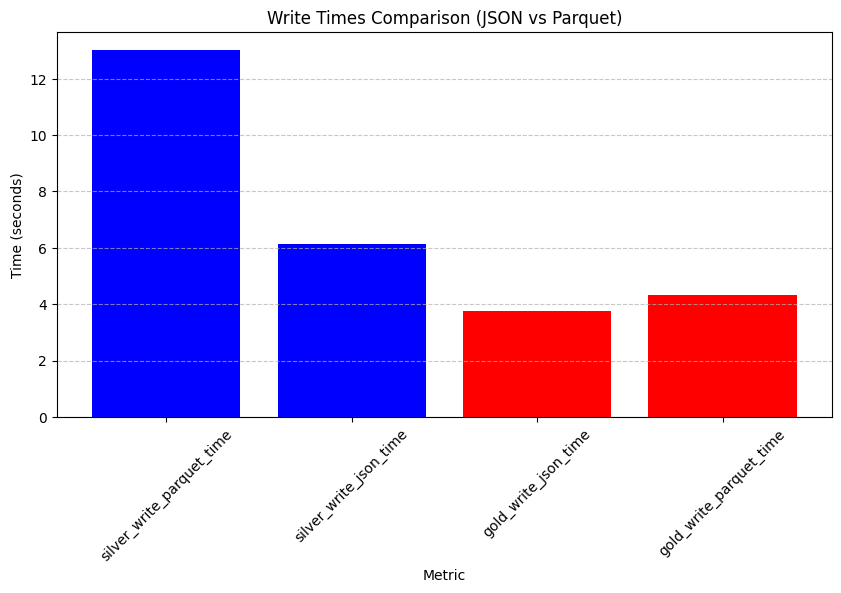

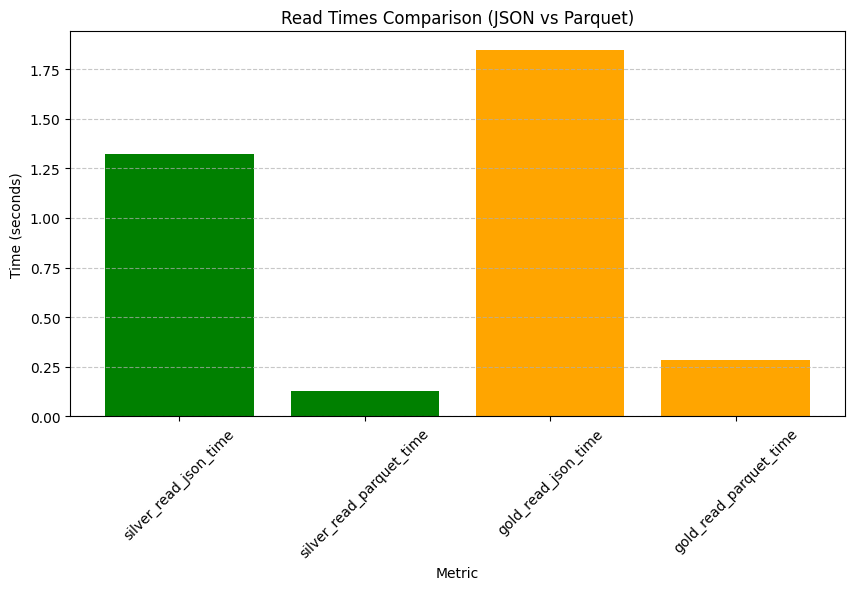

Performance charts generated successfully!


In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

data = {}
with open("performance_metrics.csv", mode="r") as file:
    reader = csv.reader(file)
    next(reader)  
    for row in reader:
        data[row[0]] = float(row[1])

write_metrics = {k: v for k, v in data.items() if "write" in k}
read_metrics = {k: v for k, v in data.items() if "read" in k}

plt.figure(figsize=(10, 5))
plt.bar(write_metrics.keys(), write_metrics.values(), color=['blue', 'blue', 'red', 'red'])
plt.title("Write Times Comparison (JSON vs Parquet)")
plt.xlabel("Metric")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(read_metrics.keys(), read_metrics.values(), color=['green', 'green', 'orange', 'orange'])
plt.title("Read Times Comparison (JSON vs Parquet)")
plt.xlabel("Metric")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Performance charts generated successfully!")
